# NMR Inversion Recovery Analysis in Python

## Objective
In this notebook, we will learn the basics of working with scientific data in Python, focusing on an NMR inversion recovery experiment. We will import experimental data into a Pandas DataFrame, calculate the T<sub>1</sub> relaxation times and ideal an ideal d<sub>1</sub> delay time, visualize the fitted data, and create a summary table.

## Inversion recovery experiment
The inversion-recovery experiment measures T1 relaxation times of any nucleus. If the net magnetization is placed along the -z axis, it will gradually return to its equilibrium position along the +z axis at a rate governed by T1. The equation governing this behavior as a function of the time t after its displacement is: 

M<sub>z</sub>(t) = M<sub>z, eq</sub> * (1 - 2 e<sup>-t/T1</sup>)

The basic pulse sequence consists of an 180<sup>°</sup> pulse that inverts the magnetization to the -z axis. During the following delay, relaxation along the longitudinal plane takes place. Magnetization comes back to the original equilibrium z-magnetization. A 90<sup>°</sup> pulse creates transverse magnetization. The experiment is repeated for a series of delay values taken from a variable delay list. A 1D spectrum is obtained for each value of vd and stored in a pseudo 2D dataset. The longer the recycle delay (d1) is, the more precise the T1 measurement is.  Ideally: `d1=5*T1`. A rough estimation of the T1 value can be calculated from the null-point value by using T1=t<sub>null</sub>/ln(2). 

![image.png](images/t1_relaxation_pulse_sequence.png)

https://imserc.northwestern.edu/downloads/nmr-t1.pdf

---

## 1. Importing Required Libraries

First, let's import the python libraries we need to work with the data.


In [25]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Enable inline plotting
%matplotlib inline

# Set DataFrame precision to 3 decimal places
pd.set_option("display.precision", 3)


---

## 2. Importing the Data

We will now import the NMR inversion recovery data from a CSV file to a Pandas Dataframe (the excel of Python).

The data file `Ibuprofen-C13-invrec-data.csv` contains columns:

|       Time       |                 Nucleus<#>                  |
| :--------------: | :-----------------------------------------: |
| Time of scan (s) | Signal for each carbon nucleus in ibuprofen |

Pro Tip: In computer languages you always start counting at 0 so the first nucleus in our dataset is labeled `Nucleus0`.

In [26]:
# Load the data from the CSV file
df = pd.read_csv('Ibuprofen-C13-invrec-data.csv')

# Display the dataframe to understand its structure
df


,Time,Nucleus0,Nucleus1,Nucleus2,Nucleus3,Nucleus4,Nucleus5,Nucleus6,Nucleus7
0,0.062,-4684.675,-5499.795,-5036.193,-6258.796,-5560.295,-27060.482,-1331.859,-2792.253
1,0.125,-3658.109,-6311.520,-5046.871,-5070.044,-5501.243,-21971.775,-2232.157,-718.401
2,0.250,-3931.386,-4594.111,-6585.526,-4965.123,-4204.978,-22386.954,-4227.647,-2714.234
3,0.500,-3852.770,-3103.076,-4563.785,-3098.568,-3719.214,-22592.487,-2123.349,-399.047
4,1.000,-4292.297,-3898.902,-6335.422,-3270.550,-2361.015,-21523.487,600.839,234.864
5,2.000,-6274.636,-458.690,-4315.249,267.014,1098.219,-20901.114,2348.319,2742.474
6,4.000,-3083.688,632.667,-3011.320,2682.380,1102.794,-18404.442,4361.105,1551.448
7,8.000,-1456.791,339.541,1444.355,4345.313,3865.516,-13650.904,3288.270,1518.069
8,16.000,-1819.283,791.616,1181.459,4085.027,5653.630,3820.513,3659.424,1841.427


---

## 3. Visualizing the Data

Let's create a function using MatPlotLib to visualize the raw data for all nuclei.


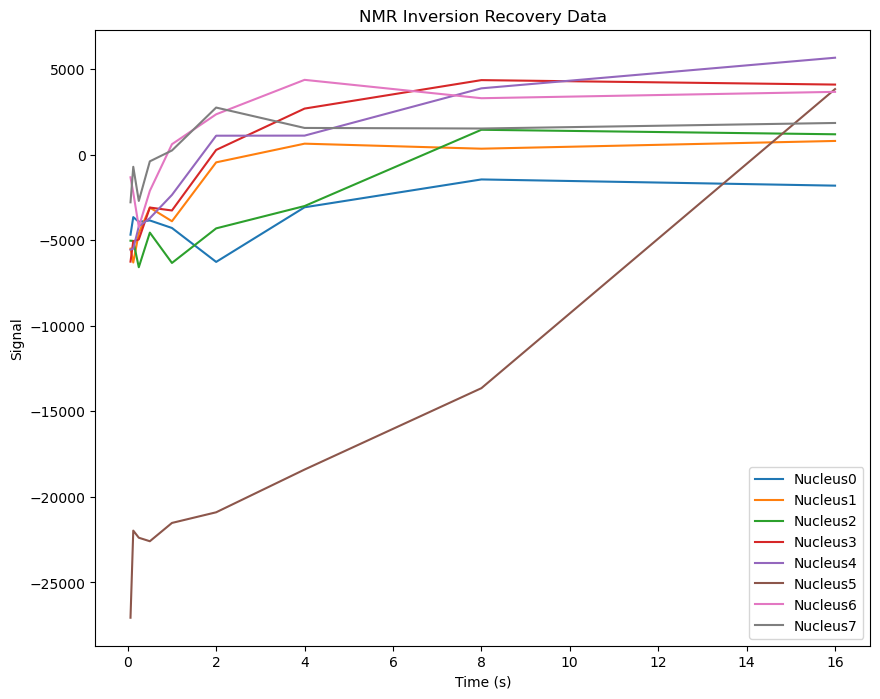

In [27]:
def plot_nmr_data(df):
    plt.figure(figsize=(10, 8))
    
    for column in df.columns:
        if column != 'Time':
            plt.plot(df['Time'], df[column], label=column)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Signal')
    plt.title('NMR Inversion Recovery Data')
    plt.legend()
    plt.show()

# Visualize the data
plot_nmr_data(df)


---

## 4. Calculating T1 Relaxation Time

To calculate the T1 relaxation time for each nucleus, we will fit the data to the inversion recovery model:

M<sub>z</sub>(t) = M<sub>z, eq</sub> * (1 - 2 e<sup>-t/T1</sup>) + C

We will create a function to perform this fitting for each nucleus.


In [28]:
# Function to model the inversion recovery curve
def inversion_recovery(t, M, T1, C):
    return M * (1 - 2 * np.exp(-t / T1)) + C

# Function to calculate T1 relaxation time for a given nucleus
def calculate_T1(df, x_col, y_col):
    t = df[x_col].values
    y = df[y_col].values
    
    # Initial guess for A, T1, and C
    initial_guess = [max(y), 1, min(y)]
    
    # Fit the curve
    popt, _ = curve_fit(inversion_recovery, t, y, p0=initial_guess)
    
    # Return the fitted parameters and T1 value
    return popt, popt[1]


---

## 5. Visualizing the Fitted Data

Let's create a function to plot the data and the fitted curve.

Functions are a module of code that is not run until called by subsequent code.

1. Define a function:

        def <function_name>(arguments):
            <function_code>

2. Run a function:

        <function_name>(arguments)


In [29]:
def plot_fitted_data(df, x_col, y_col, popt):
    t = df[x_col].values
    y = df[y_col].values
    
    plt.figure(figsize=(8, 6))
    plt.scatter(t, y, label=f'{y_col} Data')
    plt.plot(t, inversion_recovery(t, *popt), label=f'Fit: T1 = {popt[1]:.3f} s', color='red')
    plt.xlabel('Time (s)')
    plt.ylabel('Signal')
    plt.title(f'Inversion Recovery Fit for {y_col}')
    plt.legend()
    plt.show()


---

## 6. Analyzing and Summarizing T1 Times for All Nuclei

Now, let's use the functions we created to calculate the T1 relaxation time for each nucleus and visualize the fits.


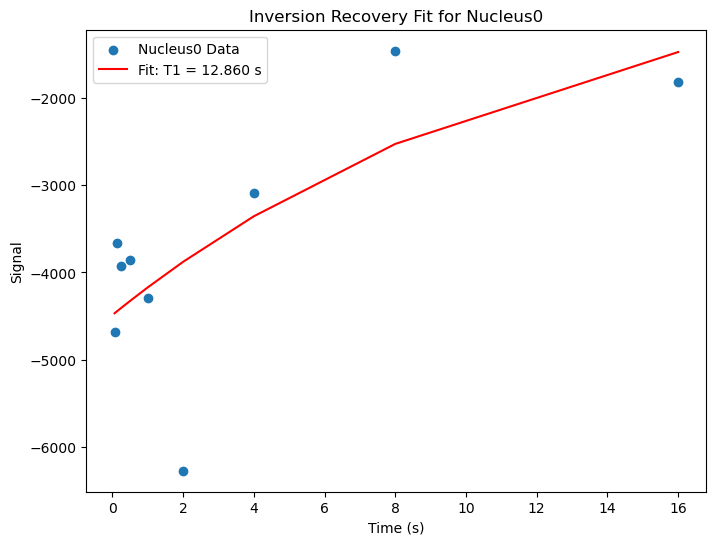

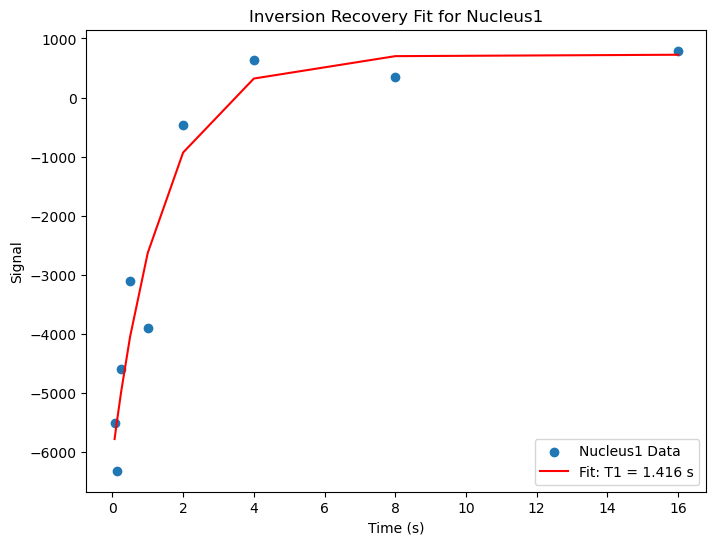

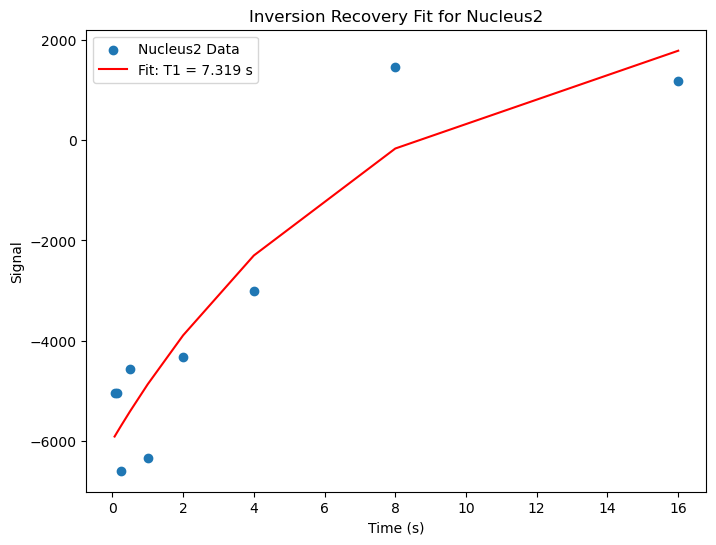

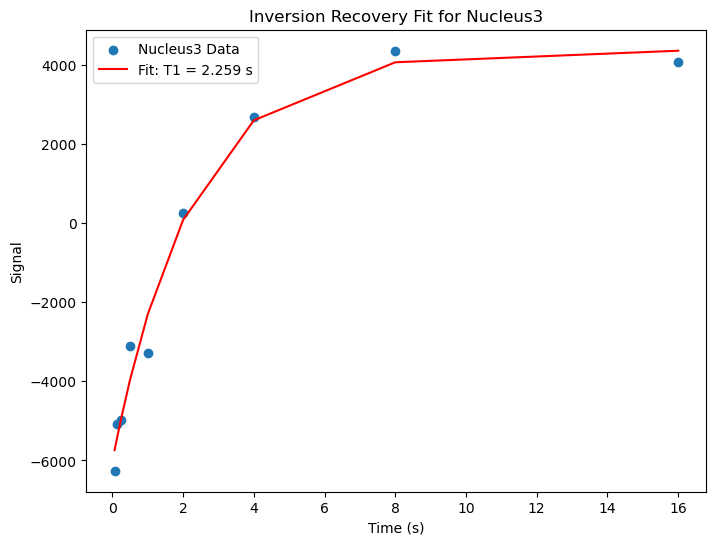

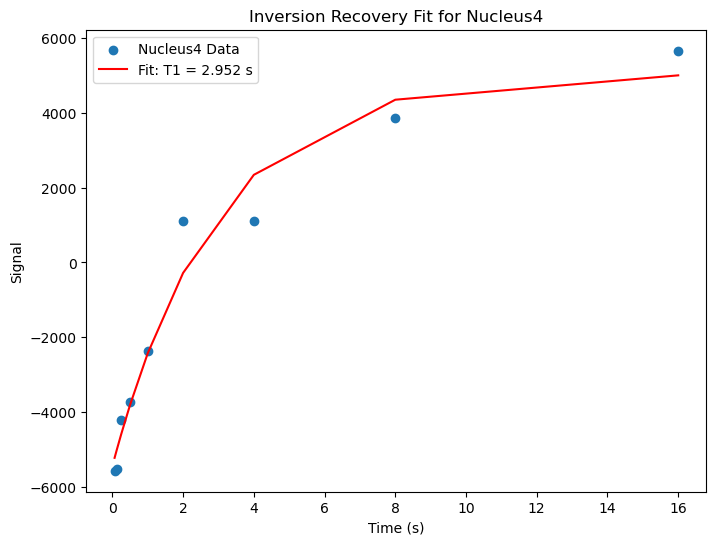

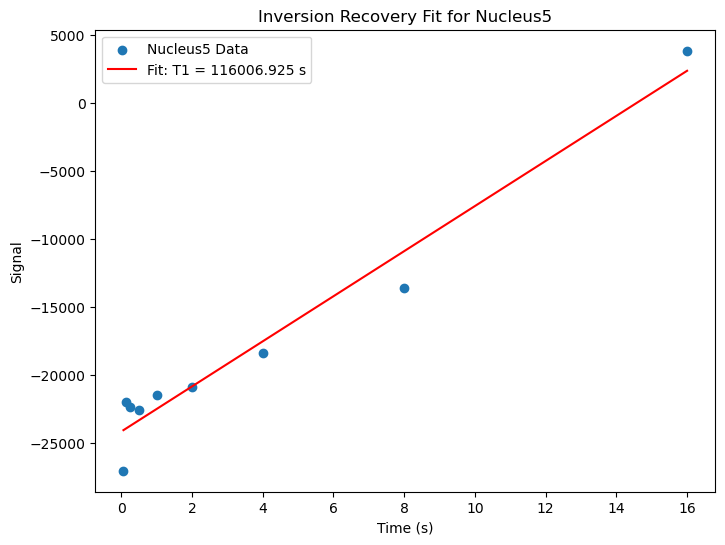

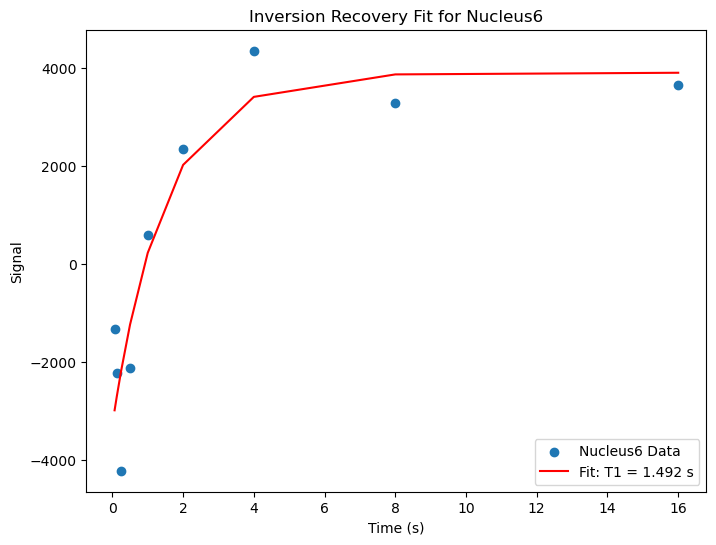

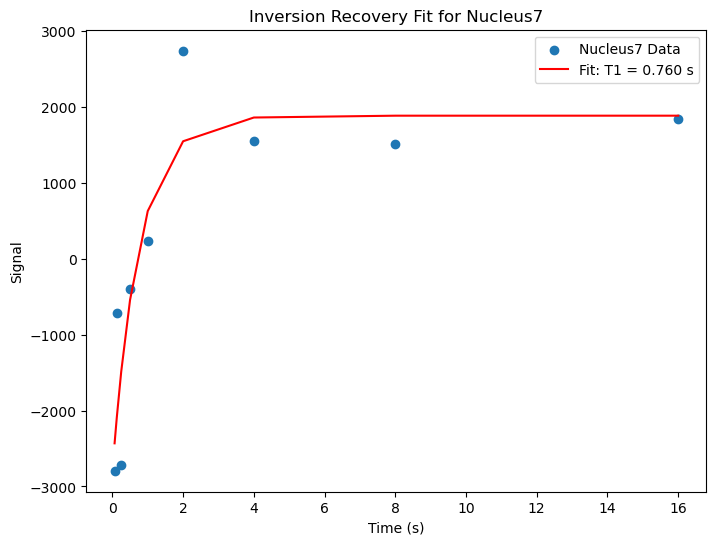

,Nucleus,T1_Time
0,Nucleus0,12.860
1,Nucleus1,1.416
2,Nucleus2,7.319
3,Nucleus3,2.259
4,Nucleus4,2.952
5,Nucleus5,116006.925
6,Nucleus6,1.492
7,Nucleus7,0.760


In [30]:
# Dictionary to store the T1 times
T1_times = {}

# Calculate T1 for each nucleus and plot the fit
for column in df.columns:
    if column != 'Time':
        popt, T1 = calculate_T1(df, 'Time', column)
        T1_times[column] = T1
        plot_fitted_data(df, 'Time', column, popt)

# Create a summary table of T1 times
T1_df = pd.DataFrame(list(T1_times.items()), columns=['Nucleus', 'T1_Time'])
T1_df


---

## 7. Calculate an ideal delay time (d<sub>1</sub>)

Now, let's calculate an ideal delay time (d<sub>1</sub>) for future NMR experiments on ibuprofen based on the (T<sub>1</sub>) times we measured.

Ideally d<sub>1</sub> should be set to:

d<sub>1</sub> = 5 * T<sub>1</sub>

Since experimental data can be imperfect we will use the interquartile range (IQR) method to exclude outliers.

In [31]:
# Calculate the d1 time for each nucleus and add to T1_df
T1_df = T1_df.eval('D1_Time = 5 * T1_Time')

# Determine IQR 
Q1 = np.percentile(T1_df['D1_Time'], 25, method='midpoint')
Q3 = np.percentile(T1_df['D1_Time'], 75, method='midpoint')
IQR = Q3 - Q1

# Calculate the upper bound for D1 (values above the upper bound are outliers)
upper_bound = Q3 + 1.5*IQR

# Find the largest D1 below the upper bound
max_d1 = T1_df['D1_Time'][T1_df['D1_Time'] < upper_bound].max()

# Round d1 time to nearest second
max_d1 = round(max_d1)

print(f'Ideal d1 time: {max_d1} (s)')
T1_df



Ideal d1 time: 64 (s)


,Nucleus,T1_Time,D1_Time
0,Nucleus0,12.860,64.301
1,Nucleus1,1.416,7.079
2,Nucleus2,7.319,36.593
3,Nucleus3,2.259,11.295
4,Nucleus4,2.952,14.758
5,Nucleus5,116006.925,580034.623
6,Nucleus6,1.492,7.461
7,Nucleus7,0.760,3.799


---

## 8. Export results

We can save the T<sub>1</sub> and d<sub>1</sub> values we calculated by exporting our summary DataFrame as a .csv file.

You can open the .csv file in excel.

In [ ]:
# Export DataFrame to a .csv file
T1_df.to_csv('ibprofen_t1_d1_summary.csv')